**Projet 7 - Implémentez un modèle de scoring**

*Auteur : Berechet Stefan, Formation OpenClassrooms Data Scientist 9 mois du 13 novembre 2020 au 13 août 2021* 


**Objectif du Projet :**

    Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
    
    Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.


In [1]:
# importation bibliothéques utiles
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
import gc
import warnings
import time
warnings.filterwarnings("ignore")

# **Partie 2 - Modélisation**

## **Chargement des données**

In [2]:
data = pd.read_csv('application_train_all_features.csv')

In [3]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total

In [4]:
# Remplacement valeurs infinies
data.replace([np.inf, -np.inf], np.nan, inplace=True)

## Traitement des données manquantes

In [5]:
# Fonction données manquantes
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)

In [6]:
find_missing(data).sort_values(['missing_ratio'], ascending=False).head(20)

,missing_count,missing_ratio
ccb_avg_drawing_amount,248339,0.807578
bur_avg_term,247239,0.804001
ccb_cur_total_limit,230816,0.750594
bur_avg_annuity,227502,0.739817
ccb_count_rej,220606,0.717392
ccb_total_limit_card,220606,0.717392
ccb_total_dpd_days,220606,0.717392
ccb_max_dpd_days,220606,0.717392
ccb_drawing_times_6m,220606,0.717392
ccb_drawing_amount_6m,220606,0.717392


### SimpleImputer sur les variables numériques

In [7]:
# Fonction pour extraire le type des variables
def feature_type_split(data, special_list=[]):
    cat_list = []
    #dis_num_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        #elif data[i].nunique() < 25:
        #    dis_num_list.append(i)
       # elif i in special_list:     # if you want to add some special cases
        #    dis_num_list.append(i)
        else:
            num_list.append(i)
    return cat_list, num_list

In [8]:
# Extraction type des variables
cat_list, num_list = feature_type_split(data)


In [9]:
find_missing(data[['SK_ID_CURR','TARGET']]).sort_values(['missing_ratio'], ascending=False)

,missing_count,missing_ratio
SK_ID_CURR,0,0.0
TARGET,0,0.0


In [10]:
# SimpleImputer
from sklearn.impute import SimpleImputer

data_num = data[num_list]

imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')


imputer_median.fit(data_num)
ar_data_num = imputer_median.transform(data_num)


data_num = pd.DataFrame(ar_data_num, columns=data_num.columns)
data_num


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total_inst_card,ccb_count_rej,ccb_max_limit_card,ccb_total_limit_card,ccb_avg_drawing_amount,ccb_cur_total_receivable,ccb_cur_total_limit,ccb_cur_total_payment,ccb_cur_total_balance,ccb_drawing_amount_1y,ccb_drawing_times_1y,ccb_drawing_amount_6m,ccb_drawing_times_6m,ccb_max_dpd_days,ccb_

### Trandofrmation des variables catégorielles (Dummies)

In [11]:
# Dummies sur les variables catégorielles
data_cat_dummies = pd.get_dummies(data[cat_list])
data_cat_dummies

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_M

In [12]:
data_clean = pd.merge(data_num, data_cat_dummies, left_index=True, right_index=True)
data_clean

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Bad debt,bur_Closed,bur_Sold,bur_currency 1,bur_currency 2,bur_currency 3,bur_currency 4,bur_Another type of loan,bur_Car loan,bur_Cash loan (non-earmarked),bur_Consumer credit,bur_Credit card,bur_Interbank credit,bur_Loan for business development,bur_Loan for purchase of shares (margin lending),bur_Loan for the purchase of equipment,bur_Loan for working capital replenishment,bur_Microloan,bur_Mobile operator loan,bur_Mortgage,bur_Real estate loan,bur_Unknown type of loan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total_inst_card,ccb_count_rej,ccb_max_limit_card,ccb_total_limit_card,ccb_avg_drawing_amount,ccb_cur_total_receivable,ccb_cur_total_limit,ccb_cur_total_payment,ccb_cur_total_balance,ccb_drawing_amount_1y,ccb_drawing_times_1y,ccb_drawing_amount_6m,ccb_drawing_times_6m,ccb_max_dpd_days,ccb_

In [13]:
find_missing(data_clean).sort_values(['missing_ratio'], ascending=False).head(10)

,missing_count,missing_ratio
SK_ID_CURR,0,0.0
pa_CODE_REJECT_REASON_HC,0,0.0
pa_NAME_CONTRACT_STATUS_Refused,0,0.0
pa_NAME_CONTRACT_STATUS_Unused offer,0,0.0
pa_NAME_PAYMENT_TYPE_Cash through the bank,0,0.0
pa_NAME_PAYMENT_TYPE_Cashless from the account of the employer,0,0.0
pa_NAME_PAYMENT_TYPE_Non-cash from your account,0,0.0
pa_CODE_REJECT_REASON_CLIENT,0,0.0
pa_CODE_REJECT_REASON_LIMIT,0,0.0
pcb_max_largedpd_days_2y,0,0.0


In [14]:
del data, data_num, data_cat_dummies

## Feature Selection 
Utilisation et inspiration du kernenl kaggle https://github.com/oskird/Kaggle-Home-Credit-Default-Risk-Solution


- select **nb_features** from 545
- **xxx_support**: list to represent select this feature or not
- **xxx_feature**: the name of selected features


Si déja fait, aller directement au chargement de la liste des features retenues

### Feature matrix and target

In [15]:
import re
data_clean = data_clean.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = data_clean.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = data_clean.TARGET

feature_name = X.columns.tolist()

In [16]:
data_clean

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TERM,OVER_EXPECT_CREDIT,MEAN_BUILDING_SCORE_AVG,TOTAL_BUILDING_SCORE_AVG,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER,SEASON_REMAINING,RATIO_INCOME_GOODS,CHILDREN_RATIO,bur_ncount,bur_act_count,bur_bad_count,bur_sold_count_x,bur_recent_application,bur_eariliest_application,bur_max_enddate,bur_avg_intervel,bur_sd_intervel,bur_max_overdue_days,bur_active_total_overdue_days,bur_active_max_overdue_days,bur_avg_remaining_days,bur_total_max_overdue_adj,bur_avg_max_overdue,bur_overall_max_overdue,bur_avg_prelonged,bur_max_prelonged,bur_total_prelonged_adj,bur_total_amount_adj,bur_avg_amount,bur_active_total_amount,bur_active_avg_amount,bur_active_total_debt,bur_active_avg_debt,bur_active_total_limit,bur_active_avg_limit,bur_active_total_overdue,bur_active_avg_overdue,bur_active_ratio_debt_credit,bur_active_ratio_overdue_debt,bur_avg_update,bur_recent_update,bur_avg_annuity,bur_total_annuity,bur_active_total_annuity,bur_avg_term,bur_Active,bur_Baddebt,bur_Closed,bur_Sold,bur_currency1,bur_currency2,bur_currency3,bur_currency4,bur_Anothertypeofloan,bur_Carloan,bur_Cashloannonearmarked,bur_Consumercredit,bur_Creditcard,bur_Interbankcredit,bur_Loanforbusinessdevelopment,bur_Loanforpurchaseofsharesmarginlending,bur_Loanforthepurchaseofequipment,bur_Loanforworkingcapitalreplenishment,bur_Microloan,bur_Mobileoperatorloan,bur_Mortgage,bur_Realestateloan,bur_Unknowntypeofloan,bb_avg_month,bb_total_overdue_month,bb_total_writeoff,bur_sold_count_y,bb_max_writeoff,bb_total_overdue_month_2year,bb_total_writeoff_2year,bb_max_overdue_month_2year,bb_max_writeoff_2year,bb_max_score,bb_total_score,bb_avg_score,ccb_prev_count,ccb_avg_inst_card,ccb_avg_limit_card,ccb_total_inst_card,ccb_count_rej,ccb_max_limit_card,ccb_total_limit_card,ccb_avg_drawing_amount,ccb_cur_total_receivable,ccb_cur_total_limit,ccb_cur_total_payment,ccb_cur_total_balance,ccb_drawing_amount_1y,ccb_drawing_times_1y,ccb_drawing_amount_6m,ccb_drawing_times_6m,ccb_max_dpd_days,ccb_total_dpd_days,ccb_max_largedpd_days,ccb_tot

### Filter
- documentation for **SelectKBest**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

####  Pearson Correlation
**Note**
- Normalization: no
- Impute missing values: yes

In [18]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [19]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


#### Chi-2

**Note**
- Normalization: MinMaxScaler (values should be bigger than 0)
- Impute missing values: yes

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x000002ABC37E09D8>)

In [21]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


### Wrapper
- documentation for **RFE**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

**Note**
- Normalization: depend on the used model; yes for LR
- Impute missing values: depend on the used model; yes for LR


In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 543 features.
Fitting estimator with 533 features.
Fitting estimator with 523 features.
Fitting estimator with 513 features.
Fitting estimator with 503 features.
Fitting estimator with 493 features.
Fitting estimator with 483 features.
Fitting estimator with 473 features.
Fitting estimator with 463 features.
Fitting estimator with 453 features.
Fitting estimator with 443 features.
Fitting estimator with 433 features.
Fitting estimator with 423 features.
Fitting estimator with 413 features.
Fitting estimator with 403 features.
Fitting estimator with 393 features.
Fitting estimator with 383 features.
Fitting estimator with 373 features.
Fitting estimator with 363 features.
Fitting estimator with 353 features.
Fitting estimator with 343 features.
Fitting estimator with 333 features.
Fitting estimator with 323 features.
Fitting estimator with 313 features.
Fitting estimator with 303 features.
Fitting estimator with 293 features.
Fitting estimator with 283 features.
F

RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10,
    verbose=5)

In [23]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


### Embeded
- documentation for **SelectFromModel**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html


#### Logistics Regression L2
**Note**
- Normalization: Yes
- Impute missing values: Yes

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(), threshold='1.25*median')

In [25]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

225 selected features


#### Random Forest
**Note**
- Normalization: No
- Impute missing values: Yes

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [27]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

249 selected features


#### LightGBM
**Note**
- Normalization: No
- Impute missing values: No

In [28]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(colsample_bytree=0.2,
                                         learning_rate=0.05,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         num_leaves=32, reg_alpha=3,
                                         reg_lambda=1),
                threshold='1.25*median')

In [29]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

252 selected features


### Summary

In [30]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(10)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,pa_PRODUCT_COMBINATION_CashXSelllow,True,True,True,True,True,True,6
2,pa_NAME_CONTRACT_STATUS_Refused,True,True,True,True,True,True,6
3,ip_total_less_times_1y,True,True,True,True,True,True,6
4,ccb_cur_total_receivable,True,True,True,True,True,True,6
5,ccb_cur_total_balance,True,True,True,True,True,True,6
6,EXT_SOURCE_3,True,True,True,True,True,True,6
7,EXT_SOURCE_2,True,True,True,True,True,True,6
8,EXT_SOURCE_1,True,True,True,True,True,True,6
9,DAYS_EMPLOYED,True,True,True,True,True,True,6
10,BIRTH_EMPLOTED_INTERVEL,True,True,True,True,True,True,6


In [31]:
# Choix de Garder les features avec un score >=3
liste_features_retenues = feature_selection_df[feature_selection_df['Total']>2]['Feature'].values.tolist()

**Sauvegarde liste_features_retenues :**

In [32]:
import pickle

# Sauvegarde
file_name = "liste_features_retenues.pkl"
open_file = open(file_name, "wb")
pickle.dump(liste_features_retenues, open_file)
open_file.close()

### Chargement Liste Features (si déja fait)

In [20]:
import pickle
# Chargement
file_name = "liste_features_retenues.pkl"
open_file = open(file_name, "rb")
liste_features_retenues = pickle.load(open_file)
open_file.close()

In [ ]:
import pickle

In [ ]:
data_clean[['SK_ID_CURR', 'TARGET']]

In [22]:
data_clean_reduit = data_clean[['SK_ID_CURR', 'TARGET']+liste_features_retenues]
data_clean_reduit

,SK_ID_CURR,TARGET,pa_PRODUCT_COMBINATION_CashXSelllow,pa_NAME_CONTRACT_STATUS_Refused,ip_total_less_times_1y,ccb_cur_total_receivable,ccb_cur_total_balance,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_EMPLOYED,BIRTH_EMPLOTED_INTERVEL,pa_total_down_payment_rate,pa_first_due_day,pa_earliest_decision_day,pa_avg_annuity,pa_NAME_YIELD_GROUP_low_action,pa_NAME_PRODUCT_TYPE_walkin,pa_CODE_REJECT_REASON_SCOFR,ip_total_late_times_6m,ip_total_late_times_1y,ip_recent_total_late_times,ip_payment_count_6m,ccb_drawing_times_6m,ccb_drawing_times_1y,ccb_cur_total_payment,bur_recent_application,bur_eariliest_application,bur_act_count,bur_Microloan,bur_Closed,bur_Active,REGION_RATING_CLIENT_W_CITY,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_BIRTH,CODE_GENDER_M,CODE_GENDER_F,AMT_GOODS_PRICE,pcb_total_dpd_days_2y,pcb_avg_month,pcb_avg_inst,pa_usage_length,pa_total_term,pa_total_annuity_adj,pa_total_annuity,pa_total_actual_credit_adj,pa_total_actual_credit,pa_max_down_payment_rate,pa_max_actual_credit,pa_get_more_credit_rate,pa_avg_goods_price,pa_avg_down_payment_rate,pa_PRODUCT_COMBINATION_POSindustrywithinterest,pa_PRODUCT_COMBINATION_CashXSellhigh,pa_PRODUCT_COMBINATION_CashStreethigh,pa_NFLAG_INSURED_ON_APPROVAL_00,pa_NAME_YIELD_GROUP_low_normal,pa_NAME_YIELD_GROUP_high,pa_NAME_PORTFOLIO_Cards,pa_NAME_CONTRACT_TYPE_Revolvingloans,pa_NAME_CONTRACT_STATUS_Approved,pa_CODE_REJECT_REASON_XAP,pa_CODE_REJECT_REASON_LIMIT,pa_CODE_REJECT_REASON_HC,ip_total_less_amount_6m,ip_total_late_times,ip_total_change_times,ip_total_actual_payment_6m,ip_recent_total_required_payment,ip_recent_total_actual_payment,ip_payment_count_1y,ip_payment_count,ip_max_instl,ip_creditcard_count_6m,ip_avg_instl_6m,ip_avg_instl,ip_avg_change_times,ccb_total_inst_card,ccb_cur_total_limit,ccb_avg_limit_card,ccb_avg_drawing_amount,bur_ncount,bur_avg_intervel,bur_active_total_limit,bur_active_avg_limit,bur_Creditcard,bur_Consumercredit,TOTAL_BUILDING_SCORE_AVG,TERM,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,OVER_EXPECT_CREDIT,ORGANIZATION_TYPE_Transporttype3,NAME_INCOME_TYPE_Pensioner,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,FLOORSMAX_MODE,FLOORSMAX_AVG,FLAG_DOCUMENT_3,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_REQ_CREDIT_BUREAU_TOTAL,AMT_CREDIT,AMT_ANNUITY,pcb_total_dpd_days,pcb_prev_count,pcb_no_largedpd,pcb_no_dpd_2y,pcb_max_dpd_days_2y,pcb_max_dpd_days,pcb_active_inst,pa_total_goods_price,pa_total_application_adj,pa_total_application,pa_recent_decision_day,pa_most_frequent_term,pa_min_freq,pa_max_term,pa_last_due_day,pa_get_more_credit_times,pa_avg_term,pa_avg_freq,pa_avg_application,pa_avg_actual_credit,pa_PRODUCT_COMBINATION_POSmobilewithinterest,pa_PRODUCT_COMBINATION_POShouseholdwithinterest,pa_PRODUCT_COMBINATION_CashStreetlow,pa_PRODUCT_COMBINATION_CardStreet,pa_NFLAG_INSURED_ON_APPROVAL_10,pa_NAME_PORTFOLIO_POS,pa_NAME_PORTFOLIO_Cash,pa_NAME_PAYMENT_TYPE_Cashthroughthebank,pa_NAME_CONTRACT_TYPE_Consumerloans,pa_NAME_CONTRACT_STATUS_Canceled,pa_NAME_CLIENT_TYPE_Repeater,pa_NAME_CLIENT_TYPE_Refreshed,ip_total_required_payment_6m,ip_total_required_payment_1y,ip_total_less_times_6m,ip_total_less_times,ip_total_less_amount_1y,ip_total_actual_payment,ip_recent_total_less_times,ip_count_6m__Revolvingloans,ip_count_1y__Consumerloans,ip_avg_instl_1y,ccb_total_limit_card,ccb_drawing_amount_6m,bur_sd_intervel,bur_avg_update,bur_avg_remaining_days,bur_Mortgage,bur_Carloan,bb_avg_score,bb_avg_month,RATIO_INCOME_GOODS,OWN_CAR_AGE,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_BusinessEntityType3,OCCUPATION_TYPE_Drivers,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,LIVE_CITY_NOT_WORK_CITY,LANDAREA_AVG,FLOORSMAX_MEDI,FLAG_WORK_PHONE,FLAG_OWN_CAR_Y,FLAG_EMP_PHONE,ENTRANCES_AVG,BIRTH_REGISTRATION_INTERVEL,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.139376,0.262949,0.083037,-637.0,8824.0,0.000000,-565.0,

## Partage données Apprentissage Modèle - Validation Modèle 80%-20%

In [28]:
# Echantillonage stratifié sur les tranches TARGET
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in split.split(data_clean_reduit, data_clean_reduit["TARGET"]):
    data_appr = data_clean_reduit.iloc[train_index]
    data_val =  data_clean_reduit.iloc[test_index]    
    
# Part de chacune des tranches  dans le jeu global
print("GLOBAL (Apprentissage+Validation) - (%) répartition TARGET :")
display (data_clean_reduit["TARGET"].value_counts()/len(data_clean_reduit["TARGET"])*100)   
 
# Part de chacune des tranches  dans le jeu de validation
print("\nAPPRENTISSAGE - (%) répartition TARGET :")
display(data_appr["TARGET"].value_counts() / len(data_appr["TARGET"])*100)    
    
# Part de chacune des tranches  dans le jeu de validation
print("\nVALIDATION - (%) répartition TARGET :")
display(data_val["TARGET"].value_counts() / len(data_val["TARGET"])*100)

GLOBAL (Apprentissage+Validation) - (%) répartition TARGET :


0.0    91.927118
1.0     8.072882
Name: TARGET, dtype: float64


APPRENTISSAGE - (%) répartition TARGET :


0.0    91.927092
1.0     8.072908
Name: TARGET, dtype: float64


VALIDATION - (%) répartition TARGET :


0.0    91.927223
1.0     8.072777
Name: TARGET, dtype: float64

## Oversampling sur data Apprentissage

le but est d'augmenter arificiellement l'effectif de TARGET 1

In [29]:
X = data_appr.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = data_appr.TARGET

### SMOTE
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [30]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 226148, 1.0: 19860})
Resampled dataset shape Counter({0.0: 226148, 1.0: 226148})


In [32]:
data_appr_balanced = pd.merge(y_res, X_res, left_index=True, right_index=True)
data_appr_balanced

,TARGET,pa_PRODUCT_COMBINATION_CashXSelllow,pa_NAME_CONTRACT_STATUS_Refused,ip_total_less_times_1y,ccb_cur_total_receivable,ccb_cur_total_balance,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_EMPLOYED,BIRTH_EMPLOTED_INTERVEL,pa_total_down_payment_rate,pa_first_due_day,pa_earliest_decision_day,pa_avg_annuity,pa_NAME_YIELD_GROUP_low_action,pa_NAME_PRODUCT_TYPE_walkin,pa_CODE_REJECT_REASON_SCOFR,ip_total_late_times_6m,ip_total_late_times_1y,ip_recent_total_late_times,ip_payment_count_6m,ccb_drawing_times_6m,ccb_drawing_times_1y,ccb_cur_total_payment,bur_recent_application,bur_eariliest_application,bur_act_count,bur_Microloan,bur_Closed,bur_Active,REGION_RATING_CLIENT_W_CITY,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_BIRTH,CODE_GENDER_M,CODE_GENDER_F,AMT_GOODS_PRICE,pcb_total_dpd_days_2y,pcb_avg_month,pcb_avg_inst,pa_usage_length,pa_total_term,pa_total_annuity_adj,pa_total_annuity,pa_total_actual_credit_adj,pa_total_actual_credit,pa_max_down_payment_rate,pa_max_actual_credit,pa_get_more_credit_rate,pa_avg_goods_price,pa_avg_down_payment_rate,pa_PRODUCT_COMBINATION_POSindustrywithinterest,pa_PRODUCT_COMBINATION_CashXSellhigh,pa_PRODUCT_COMBINATION_CashStreethigh,pa_NFLAG_INSURED_ON_APPROVAL_00,pa_NAME_YIELD_GROUP_low_normal,pa_NAME_YIELD_GROUP_high,pa_NAME_PORTFOLIO_Cards,pa_NAME_CONTRACT_TYPE_Revolvingloans,pa_NAME_CONTRACT_STATUS_Approved,pa_CODE_REJECT_REASON_XAP,pa_CODE_REJECT_REASON_LIMIT,pa_CODE_REJECT_REASON_HC,ip_total_less_amount_6m,ip_total_late_times,ip_total_change_times,ip_total_actual_payment_6m,ip_recent_total_required_payment,ip_recent_total_actual_payment,ip_payment_count_1y,ip_payment_count,ip_max_instl,ip_creditcard_count_6m,ip_avg_instl_6m,ip_avg_instl,ip_avg_change_times,ccb_total_inst_card,ccb_cur_total_limit,ccb_avg_limit_card,ccb_avg_drawing_amount,bur_ncount,bur_avg_intervel,bur_active_total_limit,bur_active_avg_limit,bur_Creditcard,bur_Consumercredit,TOTAL_BUILDING_SCORE_AVG,TERM,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,OVER_EXPECT_CREDIT,ORGANIZATION_TYPE_Transporttype3,NAME_INCOME_TYPE_Pensioner,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,FLOORSMAX_MODE,FLOORSMAX_AVG,FLAG_DOCUMENT_3,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_REQ_CREDIT_BUREAU_TOTAL,AMT_CREDIT,AMT_ANNUITY,pcb_total_dpd_days,pcb_prev_count,pcb_no_largedpd,pcb_no_dpd_2y,pcb_max_dpd_days_2y,pcb_max_dpd_days,pcb_active_inst,pa_total_goods_price,pa_total_application_adj,pa_total_application,pa_recent_decision_day,pa_most_frequent_term,pa_min_freq,pa_max_term,pa_last_due_day,pa_get_more_credit_times,pa_avg_term,pa_avg_freq,pa_avg_application,pa_avg_actual_credit,pa_PRODUCT_COMBINATION_POSmobilewithinterest,pa_PRODUCT_COMBINATION_POShouseholdwithinterest,pa_PRODUCT_COMBINATION_CashStreetlow,pa_PRODUCT_COMBINATION_CardStreet,pa_NFLAG_INSURED_ON_APPROVAL_10,pa_NAME_PORTFOLIO_POS,pa_NAME_PORTFOLIO_Cash,pa_NAME_PAYMENT_TYPE_Cashthroughthebank,pa_NAME_CONTRACT_TYPE_Consumerloans,pa_NAME_CONTRACT_STATUS_Canceled,pa_NAME_CLIENT_TYPE_Repeater,pa_NAME_CLIENT_TYPE_Refreshed,ip_total_required_payment_6m,ip_total_required_payment_1y,ip_total_less_times_6m,ip_total_less_times,ip_total_less_amount_1y,ip_total_actual_payment,ip_recent_total_less_times,ip_count_6m__Revolvingloans,ip_count_1y__Consumerloans,ip_avg_instl_1y,ccb_total_limit_card,ccb_drawing_amount_6m,bur_sd_intervel,bur_avg_update,bur_avg_remaining_days,bur_Mortgage,bur_Carloan,bb_avg_score,bb_avg_month,RATIO_INCOME_GOODS,OWN_CAR_AGE,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_BusinessEntityType3,OCCUPATION_TYPE_Drivers,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,LIVE_CITY_NOT_WORK_CITY,LANDAREA_AVG,FLOORSMAX_MEDI,FLAG_WORK_PHONE,FLAG_OWN_CAR_Y,FLAG_EMP_PHONE,ENTRANCES_AVG,BIRTH_REGISTRATION_INTERVEL,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.610991,0.137484,0.044892,-1546.000000,15579.000000,0.101666,

## Partage data Apprentissage en TRAIN-TEST 80%-20%

In [36]:
# Echantillonage stratifié sur les tranches TARGET
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in split.split(data_appr_balanced, data_appr_balanced["TARGET"]):
    data_train = data_appr_balanced.iloc[train_index]
    data_test =  data_appr_balanced.iloc[test_index]    
    
# Part de chacune des tranches  dans le jeu global
print("GLOBAL (Apprentissage équilibrée) - (%) répartition TARGET :")
display (data_appr_balanced["TARGET"].value_counts()/len(data_appr_balanced["TARGET"])*100)   
 
# Part de chacune des tranches  dans le jeu de validation
print("\nTRAIN - (%) répartition TARGET :")
display(data_train["TARGET"].value_counts() / len(data_train["TARGET"])*100)    
    
# Part de chacune des tranches  dans le jeu de validation
print("\nTEST - (%) répartition TARGET :")
display(data_test["TARGET"].value_counts() / len(data_test["TARGET"])*100)

GLOBAL (Apprentissage équilibrée) - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64


TRAIN - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64


TEST - (%) répartition TARGET :


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64

## Modélisation - Classification Binaire

In [39]:
X_train = data_train.drop(['TARGET'], axis=1)
y_train = data_train.TARGET

X_test = data_test.drop(['TARGET'], axis=1)
y_test = data_test.TARGET




### SGD Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


In [40]:
# Création et apprentissage du modèle
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [42]:
# Accuracy modèle avec Cross Validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.56602162, 0.54387623, 0.53020429])

In [44]:
# Prédiction modèles avec cross validation
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

**def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()Matrice de Confusion :**

In [46]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[148029,  32889],
       [131131,  49787]], dtype=int64)

In [49]:
# Métriques modèle

from sklearn.metrics import precision_score, recall_score, f1_score

print('precision_score                                     :',precision_score(y_train, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred)
print('precision score calculé depuis matrice de confusion :', cm[1, 1] / (cm[0, 1] + cm[1, 1]))

print('recall score                                        :', recall_score(y_train, y_train_pred))
print('recall score calculé depuis matrice de confusion    :', cm[1, 1] / (cm[1, 0] + cm[1, 1]))

print('f1 score                                            :', f1_score(y_train, y_train_pred))
print('f1 score calculé depuis matrice de confusion        :', cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2))



precision_score                                     : 0.6021941071169384
precision score calculé depuis matrice de confusion : 0.6021941071169384
recall score                                        : 0.27519097049492036
recall score calculé depuis matrice de confusion    : 0.27519097049492036
f1 score                                            : 0.3777551841088948
f1 score calculé depuis matrice de confusion        : 0.37775518410889475


In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

**Courbes Precision Recall :**

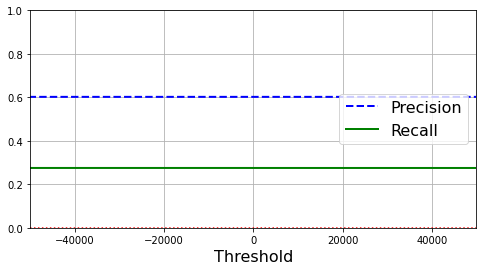

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])            


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
                                          
plt.show()

In [56]:
(y_train_pred == (y_scores > 0)).all()

True

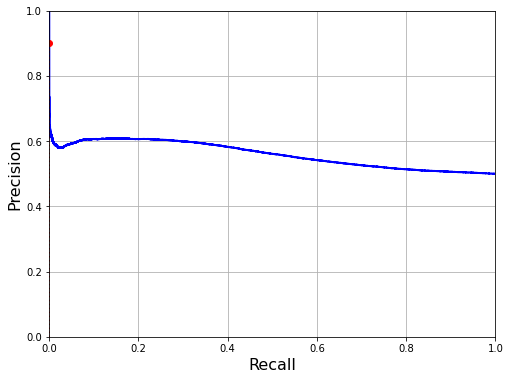

In [57]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

**Courbe ROC :**

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

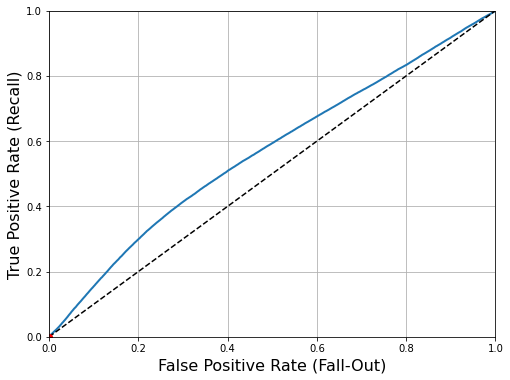

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
                                
plt.show()

In [61]:
from sklearn.metrics import roc_auc_score

print('ROC score :', roc_auc_score(y_train, y_scores))

ROC score : 0.5656486874092758


### Random Forest Classifier

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")

In [63]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

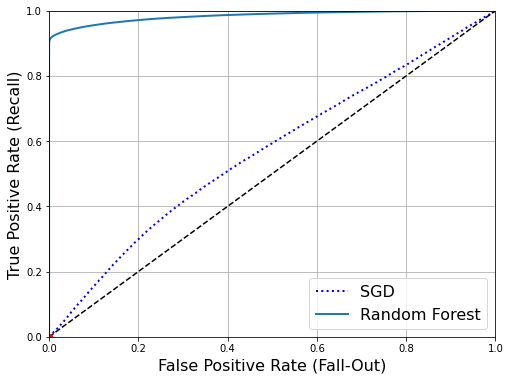

In [64]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [65]:
print('ROC score        :', roc_auc_score(y_train, y_scores_forest))

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)

print('precision score :', precision_score(y_train, y_train_pred_forest))
print('recall score    :', recall_score(y_train, y_train_pred_forest))
print('f1 score        :', f1_score(y_train, y_train_pred_forest))


ROC score        : 0.9836219540829332
precision score : 0.996037329677334
recall score    : 0.9155694845178479
f1 score        : 0.9541097863026324


In [68]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Apprentissage
forest_clf.fit(X_train, y_train)



NameError: name 'nlr_RFR' is not defined

In [70]:
# Prédictions sur le jeu TEST
y_test_pred_forest = forest_clf.predict(X_test)


print('precision score TEST :', precision_score(y_test, y_test_pred_forest))
print('recall score TEST    :', recall_score(y_test, y_test_pred_forest))
print('f1 score TEST        :', f1_score(y_test, y_test_pred_forest))

precision score TEST : 0.997372354274143
recall score TEST    : 0.9147247402166704
f1 score TEST        : 0.954262385828951


In [74]:
# Prédictions sur le jeu VALIDATION
X_val = data_val.drop(['TARGET','SK_ID_CURR'], axis=1)
y_val = data_val.TARGET

y_val_pred_forest = forest_clf.predict(X_val)


print('precision score VALIDATION :', precision_score(y_val, y_val_pred_forest))
print('recall score VALIDATION    :', recall_score(y_val, y_val_pred_forest))
print('f1 score VALIDATION        :', f1_score(y_val, y_val_pred_forest))

precision score VALIDATION : 0.41847826086956524
recall score VALIDATION    : 0.015508559919436053
f1 score VALIDATION        : 0.02990872013983298
